In [123]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import altair as alt
import pandas as pd

In [124]:
df= pd.read_csv("../Data_csv/data_preprocessed.csv")[["Name of the document", "Institution", "text_processed", "theme"]]

In [125]:
def count_words(texts, voc = None):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    n_samples = len(texts)
    if voc == None:
        words = set()
        for text in texts:
            words = words.union(set(text)) # list of all words
        n_features = len(words) # number of different words
        vocabulary = dict(zip(words, range(n_features))) # vocab[wd] = index ; indexisation
    else:
        vocabulary = voc
        n_features = len(voc)
    counts = np.zeros((n_samples, n_features))
    for k, text in enumerate(texts): # enumeration a k for a text[k]
        for w in text:
            if w in vocabulary:
                counts[k][vocabulary[w]] += 1.
    return vocabulary, counts

In [126]:
# Create and fit the vectorizer to the training data
dates = set([str(i) for i in range(1990, 2025)])
custom_stop_words = ['ai', 'data', 'maxwidth', 'px', 'maxheight', 'img', 'src', 'https', 'com', 'www', 'http', 'jpg', 'png', 'gif', 'jpeg', 'pdf', 'html', 'grid','body', ':root', '\n', 'padding',',button','margintop', 'px', 'margin', 'border', 'width', 'height', 'color', 'font', 'size', 'background', 'position', 'left', 'right', 'top', 'bottom', 'display', 'flex', 'align', 'justify', 'content', 'center', 'float', 'clear', 'overflow', 'hidden', 'zindex', 'cursor', 'pointer', 'hover', 'active', 'focus', 'transition', 'transform', 'rotate', 'scale', 'translate', 'opacity', 'box', 'shadow', 'outline', 'none', 'block', 'inline', 'inlineblock', 'relative', 'absolute', 'fixed', 'static', 'sticky', 'visible', 'hidden']
custom_stop_words += dates
vectorizer = CountVectorizer(stop_words=custom_stop_words)
Bow = vectorizer.fit_transform(df['text_processed'])
bow_a = Bow.toarray()
voc_a = vectorizer.vocabulary_
print(bow_a.shape)

c:\Users\bapti\projet_NLP\env_projet_NLP\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['button', 'root'] not in stop_words.
  warnings.warn(


(457, 139687)


In [127]:
frequency = bow_a.sum(axis = 0)
top_words = np.argsort(frequency)[::-1]

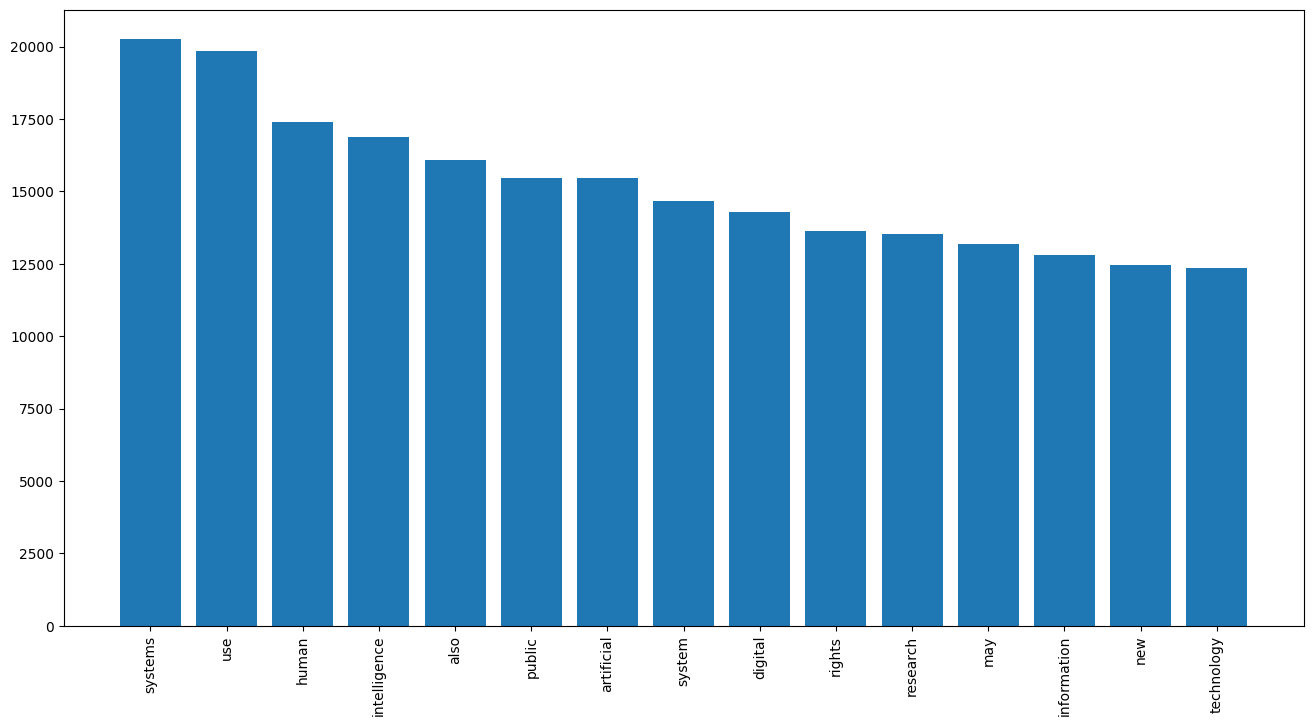

In [128]:
rev_voc = {i: w for w, i in voc_a.items()}
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(15), frequency[top_words[:15]])
ax.set_xticks(range(15))
ax.set_xticklabels([rev_voc[i] for i in top_words[:15]], rotation='vertical')
plt.show()

In [129]:
def euclidean(u, v):
    return np.linalg.norm(u-v)

def length_norm(u):
    return u / np.sqrt(u.dot(u))

def cosine(u, v):
    return 1.0 - length_norm(u).dot(length_norm(v))



In [130]:


def tfidf_transform(bow):
    """
    Inverse document frequencies applied to our bag-of-words representations
    """
    # IDF
    d = float(bow.shape[0]) + 1.0
    in_doc = bow.astype(bool).sum(axis=0) + 1.0
    idfs = np.log(d / in_doc) + 1.0
    # TF
    sum_vec = bow.sum(axis=1)
    tfs = bow / np.expand_dims(sum_vec + 1.0, axis=1)
    tf_idf = tfs * np.expand_dims(idfs,axis=0)
    return tf_idf

In [131]:
tfidf = tfidf_transform(bow_a)
print(tfidf.shape)

(457, 139687)


### III - 3 Topic modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension before visualization. 

The underlying idea is to **take advantage of the latent structure in the association between the set of
words and the set of documents**. Many methods have been designed to do this - the earliest being **topic models**. 

Note that this allows to obtain reduced document representations, in a **topic space, common to documents and words** - where each document is described as a vector of topics and for each topic, we have access to the importance of words. 


We will do this with two models:
- Using the ```TruncatedSVD```, we will **linearly** reduce the dimension of our BOW representations. This is called *Latent Semantic Analysis* (LSA). 
- Using a *generative model* based on several assumptions on how a document is generated through topics, which the model will retrieve: this is ```LatentDirichletAllocation``` (LDA).

We use here another dataset from this [paper](https://aclanthology.org/2024.latechclfl-1.28/) which includes quite more categories and will be more interesting to explore, as we can expect it to contain clusters clearly visible through looking at lexical features. You can find the dataset on their [git repository](https://git.unistra.fr/thealtres/stage-direction-classif-french-transfer-learning).

**Latent Dirichlet Allocation**: 

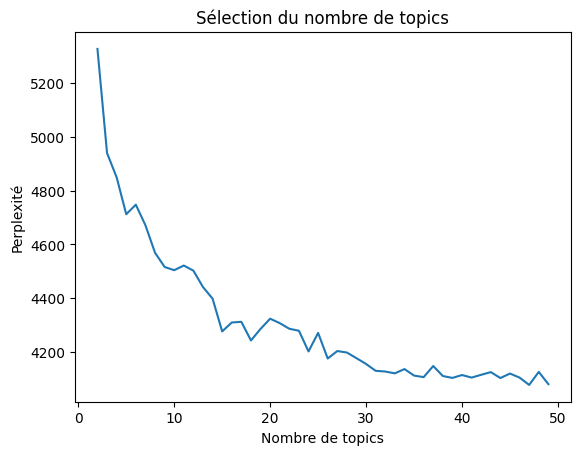

In [ ]:
perplexities = []
for k in range(2, 50):  # Tester différents nombres de topics
    lda_model = LatentDirichletAllocation(n_components=k, random_state=42)
    lda_model.fit(bow_a)  # bow est votre matrice de document-terme
    perplexities.append(lda_model.perplexity(bow_a))

# Tracer la perplexité
plt.plot(range(2, 50), perplexities)
plt.xlabel("Nombre de topics")
plt.ylabel("Perplexité")
plt.title("Sélection du nombre de topics")
plt.show()



nombre de topics intéressants: 5, 10, 15

In [132]:
# Reversing the vocabulary to retrieve words from indexes, allowing to find the most important words for each topic
rev_voc_th = {i: w for w, i in voc_a.items()}

In [133]:
n_topics = 10
lda = LatentDirichletAllocation(n_components = n_topics)
lda_topics_th = lda.fit_transform(bow_a)

In [134]:
words = most_important_words(10, rev_voc_th, lda)
for i, topic in enumerate(words[:15]):
    print("Topic ", i+1, " : ", topic)

Topic  1  :  ['digital', 'government', 'new', 'development', 'public', 'research', 'services', 'sector', 'also', 'innovation']
Topic  2  :  ['biometric', 'recognition', 'facial', 'law', 'rights', 'media', 'european', 'enforcement', 'article', 'artificial']
Topic  3  :  ['ethics', 'work', 'human', 'ethical', 'systems', 'technologies', 'use', 'technology', 'people', 'social']
Topic  4  :  ['intelligence', 'report', 'index', 'figure', 'artificial', 'number', 'research', 'blockchain', 'global', 'papers']
Topic  5  :  ['rights', 'human', 'use', 'systems', 'public', 'intelligence', 'may', 'also', 'org', 'information']
Topic  6  :  ['oecd', 'skills', 'et', 'de', 'training', 'external', 'employment', 'using', 'labour', 'related']
Topic  7  :  ['learning', 'machine', 'wsf', 'al', 'tion', 'systems', 'field', 'example', 'ts', 'ed']
Topic  8  :  ['intelligence', 'artificial', 'research', 'development', 'public', 'national', 'strategy', 'systems', 'technology', 'use']
Topic  9  :  ['information', '

In [135]:
# Pour chaque document, trouvez l'index du topic dominant
dominant_topics = lda_topics_th.argmax(axis=1)



In [136]:
docs_tsne_th = TSNE(n_components=2, learning_rate='auto',
                  init='pca', metric='cosine', perplexity=50.0).fit_transform(lda_topics_th)
print(docs_tsne_th.shape)

data_th = pd.DataFrame({'x': docs_tsne_th[:,0],
                        'y': docs_tsne_th[:,1],
                        #'theme': df['theme']})
                        'theme': dominant_topics })

alt.data_transformers.disable_max_rows()
alt.Chart(data_th[:]).mark_circle(size=200).encode(
    x="x", 
    y="y", 
    color=alt.Color('theme:N', scale=alt.Scale(scheme='category20')),
    tooltip=['theme']
).interactive().properties(
    width=500,
    height=500
)

(457, 2)


alt.Chart(...)